[ 97  99  76 123 100  63  62  60 105  85]
[255 255   0 255 255   0   0   0 255   0]


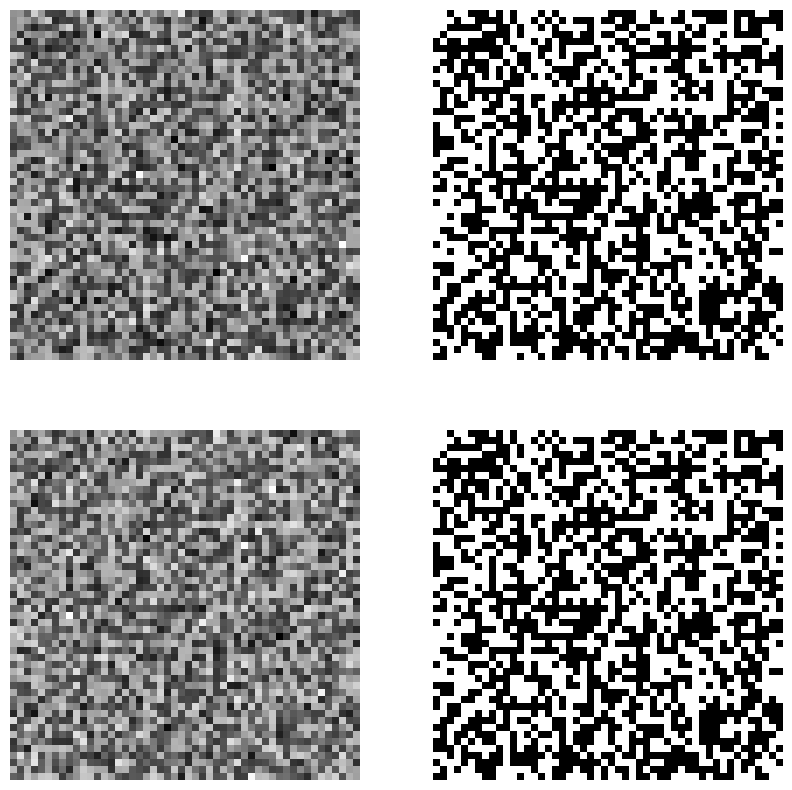

In [2]:

import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from tqdm import trange

barcodeA = imread('MGBarcodesA/2Dbarcode1.pgm')
barcodeAOri = imread('MGBarcodesA/OriginalCode.pgm')

print(barcodeA.flatten()[:10])
print(barcodeAOri.flatten()[:10])

barcodeF = imread('MGBarcodesF/2Dbarcode1.pgm')
barcodeFOri = imread('MGBarcodesF/OriginalCode.pgm')

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes[0, 0].imshow(barcodeA, cmap="gray")
axes[0, 0].axis('off')
axes[0, 1].imshow(barcodeAOri, cmap="gray")
axes[0, 1].axis('off')

axes[1, 0].imshow(barcodeF, cmap="gray")
axes[1, 0].axis('off')
axes[1, 1].imshow(barcodeFOri, cmap="gray")
axes[1, 1].axis('off')
plt.show()

# Attaquant

In [3]:



def f(zi, mu, sigma2):
    return (1 / (np.sqrt(2 * np.pi) * sigma2)) * np.exp(-(zi - mu) ** 2 / (2 * sigma2))


def EMAlg(scan, N):
    K = 2
    alphas = np.ones(K) / K
    #mus = np.random.choice(scan, K)
    mus = np.array([50, 150], dtype=np.float64)
    #sigmas = np.ones(K)
    sigmas = np.array([100, 100], dtype=np.float64)
    scan_len = len(scan)

    for _ in trange(N):
        pnums = np.zeros((scan_len, K))
        for k in range(K):
            pnums[:, k] = alphas[k] * f(scan, mus[k], sigmas[k])

        pnums /= np.sum(pnums, axis=1, keepdims=True)

        for k in range(K):
            p_sum = np.sum(pnums[:, k])

            mus[k] = np.sum(scan * pnums[:, k]) / p_sum
            sigmas[k] = np.sum(pnums[:, k] * (scan - mus[k]) ** 2) / p_sum
            alphas[k] = p_sum / scan_len

    return alphas, mus, sigmas

In [4]:
test_scan = barcodeA.flatten()  #/ 255
alphas, mus, sigmas = EMAlg(test_scan, 10)

print(alphas, mus, sigmas)

100%|██████████| 10/10 [00:00<00:00, 4312.47it/s]

[0.50217562 0.49782438] [ 64.80670767 105.45496276] [110.19525291 111.72312047]


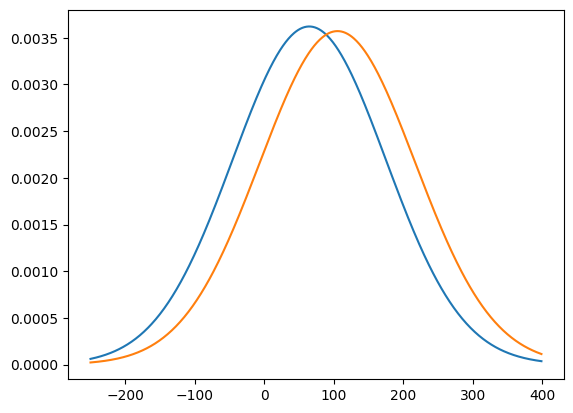

In [5]:
from scipy.stats import norm

#x_axis = np.arange(0.20, 0.45, 0.0001)
x_axis = np.arange(-250, 400, 1)

plt.plot(x_axis, norm.pdf(x_axis, mus[0], sigmas[0]))
plt.plot(x_axis, norm.pdf(x_axis, mus[1], sigmas[1]))
plt.show()

85.13083521236786
[ 97  99  76 ...  60 114 110]
[255 255   0 255 255   0   0   0 255   0 255   0 255 255 255   0 255   0
 255   0]
[ 97  99  76 123 100  63  62  60 105  85 121  48 100 111  97  61 101  54
 114  84]
[255 255   0 255 255   0   0   0 255   0 255   0 255 255 255   0 255   0
 255 255]
97.84%


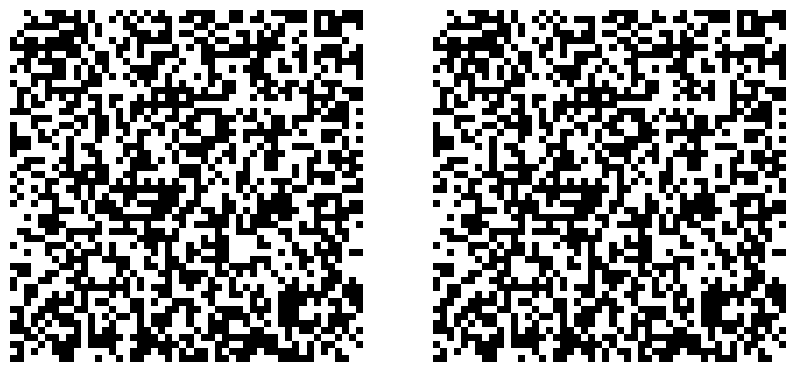

In [6]:
seuil = np.mean(mus)
tmp_sigs = sigmas / np.sum(sigmas)
#seuil = (max(mus) - min(mus)) / tmp_sigs[0]
#seuil = (mus[1] * sigmas[0] - sigmas[1] * mus[0]) / (sigmas[1] - sigmas[0])
print(seuil)

print(test_scan)
test_orig = np.where(test_scan > seuil, 255, 0).reshape(50, 50)

print(test_orig.flatten()[:20])
print(barcodeA.flatten()[:20])
print(barcodeAOri.flatten()[:20])

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(test_orig, cmap="gray")
axes[0].axis('off')
axes[1].imshow(barcodeAOri, cmap="gray")
axes[1].axis('off')

print(f"{len(np.where(test_orig.flatten() == barcodeAOri.flatten())[0]) / 50 / 50 * 100}%")

# 2

## 2.1

In [22]:
mu1 = 65
mu2 = 105
sigma1 = sigma2 = 105
seuil = 85

#nbBlacks = len(np.where(image == 0)[0])
#nbWhite = len(np.where(image == 255)[0])

Pbw = 0
Pwb = 0

for k in range(256):
    if k < seuil:
        Pwb += f(k, mu2, sigma2)
    else:
        Pbw += f(k, mu1, sigma1)


def calcLambda(image, origin):
    N = image.shape[0] * image.shape[1]

    LAMBDA = 0
    imageFlat = image.flatten()
    originFlat = origin.flatten()
    for i in range(N):
        if originFlat[i] == 0:  # black
            LAMBDA += (imageFlat[i] - mu1) ** 2 / sigma1 / 2
            LAMBDA += np.log(np.sqrt(2 * np.pi * sigma1))
            #print((imageFlat[i] - mu1) ** 2 / sigma1 / 2)
            LAMBDA += np.log((1 - Pbw) / (np.sqrt(2 * np.pi * sigma1)) * np.exp(-1 / 2 * (imageFlat[i] - mu1) ** 2 / sigma1) + Pbw / (
                np.sqrt(2 * np.pi * sigma2)) * np.exp(-1 / 2 * (imageFlat[i] - mu2) ** 2 / sigma2))
        elif originFlat[i] == 255:
            LAMBDA += (imageFlat[i] - mu2) ** 2 / sigma2 / 2
            LAMBDA += np.log(np.sqrt(2 * np.pi * sigma2))
            LAMBDA += np.log((1 - Pwb) / (np.sqrt(2 * np.pi * sigma2)) * np.exp(-1 / 2 * (imageFlat[i] - mu2) ** 2 / sigma2) + Pwb / (
                np.sqrt(2 * np.pi * sigma1)) * np.exp(-1 / 2 * (imageFlat[i] - mu1) ** 2 / sigma1))

    return LAMBDA

In [23]:
t1 = calcLambda(barcodeAOri, barcodeAOri)
t2 = calcLambda(barcodeA, barcodeAOri)
t3 = calcLambda(barcodeF, barcodeAOri)
t4 = calcLambda(test_orig, barcodeAOri)

print(t1, t2, t3, t4)

-6.247059331299454 -4.677179005593064 177.94952989718618 2129.717676324239


In [9]:
def relative_entropy(image, origin):
    imageFlat = image.flatten()
    originFlat = origin.flatten()
    N = len(originFlat)
    summ = 0
    for i in range(N):
        if originFlat[i] == 0:  # black
            summ += ((1 - Pbw) * f(imageFlat[i], mu1, sigma1) + Pbw * f(imageFlat[i], mu2, sigma2)) * np.log2(
                ((1 - Pbw) * f(imageFlat[i], mu1, sigma1) + Pbw * f(imageFlat[i], mu2, sigma2)) / f(imageFlat[i], mu1,
                                                                                                    sigma1))
        elif originFlat[i] == 255:
            summ += ((1 - Pwb) * f(imageFlat[i], mu2, sigma2) + Pwb * f(imageFlat[i], mu1, sigma1)) * np.log2(
                ((1 - Pwb) * f(imageFlat[i], mu2, sigma2) + Pwb * f(imageFlat[i], mu1, sigma1)) / f(imageFlat[i], mu2,
                                                                                                    sigma2))
    return summ

In [28]:
goods = []
goodsEnt = []
orrrrrr = imread(f"BarcodesA/OriginalCode.pgm")
for i in trange(1, 10001):
    img = imread(f"BarcodesA/2Dbarcode{i}.pgm")
    lm = calcLambda(img, orrrrrr)
    goods.append(lm)
    goodsEnt.append(relative_entropy(img, orrrrrr))

fakes = []
fakesEnt = []
for i in trange(1, 10001):
    img = imread(f"BarcodesF/2Dbarcode{i}.pgm")
    lm = calcLambda(img, orrrrrr)
    fakes.append(lm)
    fakesEnt.append(relative_entropy(img, orrrrrr))

100%|██████████| 10000/10000 [02:01<00:00, 82.36it/s]


In [ ]:
print(goodsEnt[:10])
print(fakesEnt[:10])

[8963  676  188   90   32   31   13    3    1    3] [-0.63091029 -0.01709895  0.59671239  1.21052373  1.82433507  2.43814641
  3.05195775  3.66576909  4.27958043  4.89339177  5.50720311]


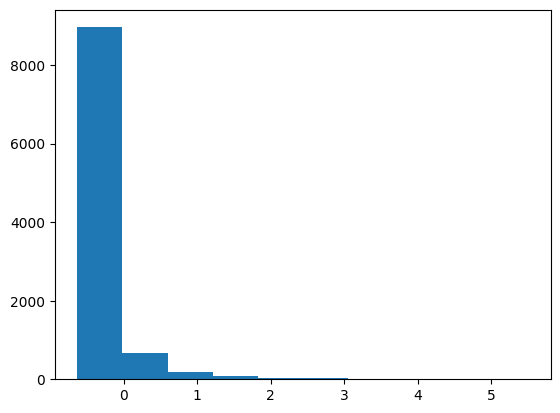

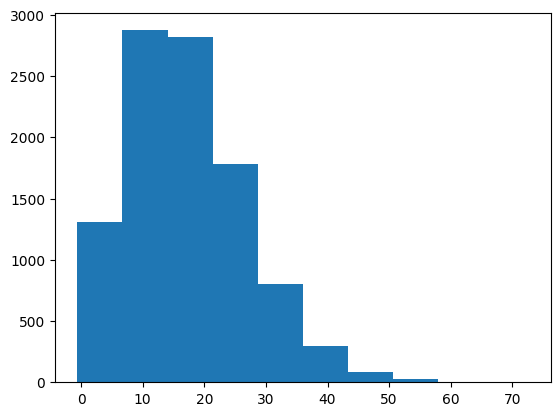

In [51]:
a, counts = np.histogram(goods)
print(a, counts)

plt.figure()
plt.hist(goods)
plt.figure()
plt.hist(fakes)
plt.show()

# 2.2

In [31]:
imgs_A = []
imgs_F = []

imgs_orr = imread(f"BarcodesA/OriginalCode.pgm")
for i in trange(1, 10001):
    imgs_A.append(imread(f"BarcodesA/2Dbarcode{i}.pgm"))

for i in trange(1, 10001):
    imgs_F.append(imread(f"BarcodesF/2Dbarcode{i}.pgm"))

100%|██████████| 10000/10000 [00:04<00:00, 2360.08it/s]


In [82]:
roc_good = {}
#roc_good_X = np.array(range(-20, 1, 1))
roc_good_X = np.linspace(-1, 1, 40)

for img in trange(10000):
    ccc = calcLambda(imgs_A[img], imgs_orr)
    for i in roc_good_X:
        if ccc >= i:
            if i not in roc_good:
                roc_good[i] = 1
            roc_good[i] += 1

print(roc_good)

100%|██████████| 10000/10000 [00:48<00:00, 207.01it/s]

{-1.0: 10001, -0.9487179487179487: 10001, -0.8974358974358975: 10001, -0.8461538461538461: 10001, -0.7948717948717949: 10001, -0.7435897435897436: 10001, -0.6923076923076923: 10001, -0.641025641025641: 10001, -0.5897435897435898: 8923, -0.5384615384615385: 6372, -0.4871794871794872: 4678, -0.4358974358974359: 3617, -0.3846153846153846: 2867, -0.33333333333333337: 2379, -0.28205128205128205: 2008, -0.23076923076923084: 1732, -0.17948717948717952: 1498, -0.1282051282051282: 1316, -0.07692307692307698: 1164, -0.02564102564102566: 1061, 0.02564102564102555: 950, 0.07692307692307687: 855, 0.1282051282051282: 775, 0.17948717948717952: 697, 0.23076923076923084: 633, 0.28205128205128194: 574, 0.33333333333333326: 526, 0.3846153846153846: 486, 0.4358974358974359: 453, 0.4871794871794872: 418, 0.5384615384615383: 386, 0.5897435897435896: 364, 0.641025641025641: 344, 0.6923076923076923: 327, 0.7435897435897436: 304, 0.7948717948717947: 288, 0.846153846153846: 277, 0.8974358974358974: 254, 0.94871

In [ ]:
print(roc_good_X)
print(roc_good)

In [83]:
roc_fake = {}
#roc_fake_X = np.array(range(-20, 1, 1))
roc_fake_X = np.linspace(-1, 1, 40)

for img in trange(10000):
    ccc = calcLambda(imgs_F[img], imgs_orr)
    for i in roc_fake_X:
        if ccc >= i:
            if i not in roc_fake:
                roc_fake[i] = 1
            roc_fake[i] += 1
print(roc_fake)

100%|██████████| 10000/10000 [00:48<00:00, 204.69it/s]

{-1.0: 10001, -0.9487179487179487: 10001, -0.8974358974358975: 10001, -0.8461538461538461: 10001, -0.7948717948717949: 10001, -0.7435897435897436: 10001, -0.6923076923076923: 10001, -0.641025641025641: 10001, -0.5897435897435898: 10000, -0.5384615384615385: 9991, -0.4871794871794872: 9983, -0.4358974358974359: 9980, -0.3846153846153846: 9976, -0.33333333333333337: 9969, -0.28205128205128205: 9960, -0.23076923076923084: 9957, -0.17948717948717952: 9952, -0.1282051282051282: 9940, -0.07692307692307698: 9937, -0.02564102564102566: 9932, 0.02564102564102555: 9927, 0.07692307692307687: 9921, 0.1282051282051282: 9912, 0.17948717948717952: 9909, 0.23076923076923084: 9903, 0.28205128205128194: 9894, 0.33333333333333326: 9889, 0.3846153846153846: 9884, 0.4358974358974359: 9880, 0.4871794871794872: 9878, 0.5384615384615383: 9875, 0.5897435897435896: 9870, 0.641025641025641: 9866, 0.6923076923076923: 9859, 0.7435897435897436: 9852, 0.7948717948717947: 9847, 0.846153846153846: 9843, 0.897435897435

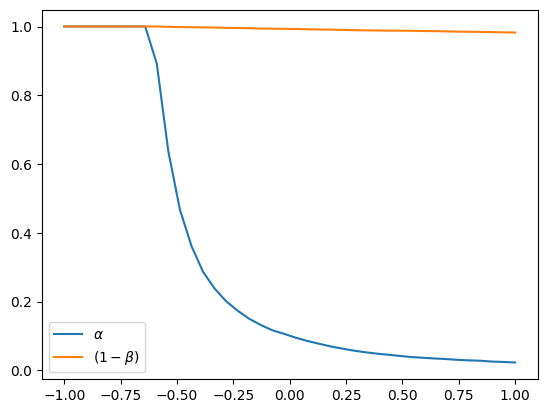

In [84]:
plt.plot(roc_good_X, np.array(list(roc_good.values())) / 10000, label='$\\alpha$')
plt.plot(roc_fake_X, np.array(list(roc_fake.values())) / 10000, label='$(1-\\beta)$')
plt.legend()

plt.show()
#plt.plot(roc_fake_X, roc_fake / 10000)

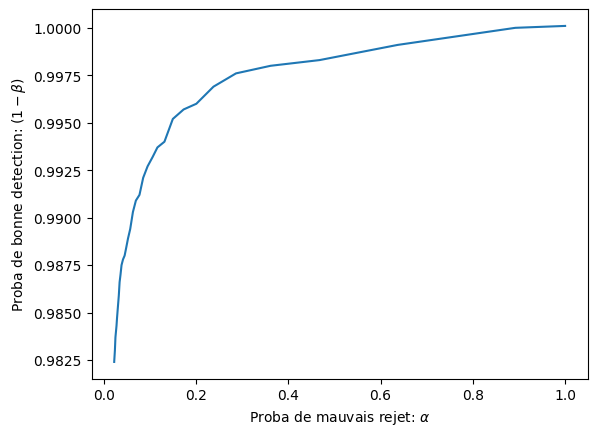

In [85]:
plt.plot(np.array(list(roc_good.values())) / 10000, np.array(list(roc_fake.values())) / 10000)
plt.xlabel('Proba de mauvais rejet: $\\alpha$')
plt.ylabel('Proba de bonne detection: $(1-\\beta)$')
plt.show()

# 2.3
on se base sur les courbes rocs pour extraire le lambda correspondant a un alpha de 10e-2/10e-1

In [95]:
alphazz = np.array(list(roc_good.values())) / 10000
lambda1 = roc_good_X[np.where(alphazz < 10e-2)[0][0]]
lambda2 = roc_good_X[np.where(alphazz < 10e-1)[0][0]]
print(lambda1)
print(lambda2)

0.02564102564102555
-0.5897435897435898


In [102]:
orr_code = imread('Testcodes/OriginalCode.pgm')
codes = [imread(f'Testcodes/2Dbarcode{i}.pgm') for i in range(1, 11)]

print("\t\t\t\t\t   10e-2 | 10e-1")
for i, code in enumerate(codes):
    lm = calcLambda(code, orr_code)
    print(f"2Dbarcode{i + 1}: Vrai code? {lm < lambda1} | {lm < lambda2}")

					   10e-2 | 10e-1
2Dbarcode1: Vrai code? True | True
2Dbarcode2: Vrai code? False | False
2Dbarcode3: Vrai code? True | False
2Dbarcode4: Vrai code? True | False
2Dbarcode5: Vrai code? False | False
2Dbarcode6: Vrai code? True | False
2Dbarcode7: Vrai code? False | False
2Dbarcode8: Vrai code? False | False
2Dbarcode9: Vrai code? True | False
2Dbarcode10: Vrai code? True | False
